# DRLN Demo (Linux only)

This notebook provides a demo using the attention-based DRLN model for Super Resolution. The code and pretrained models are taken from the [GitHub](https://github.com/saeed-anwar/DRLN) repository bleonging to the paper about DRLN (Densely Residual Laplacian Super-Resolution) by Saeed Anwar and Nick Barnes.



Unfortunateley, the paper is very recent and the authors do not provide a finished training pipeline (although the code of the architecture is in principle there), however, one can use their pretrained models for testing.

The code is yet a bit messy since they based their implementation heavily on the more previous [RCAN](https://github.com/yulunzhang/RCAN) model and they still seem to be some leftover artifacts due to that. 

However, I got the testing pipeline to work and you even can plug in your own pictures.

## Setting up

You need to install pytorch and some other dependencies in order to run your code. I propose using the provided .yml  to create a fitting conda environment (if you haven't install Mini-/Anaconda please follow these [instructions](https://docs.conda.io/projects/conda/en/latest/user-guide/install/linux.html)).
When you run into trouble adding the environment to your jupyter notebook follow these [instructions](https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084).

In [1]:
%%bash
conda env create -f Demo_DRLN.yml # may take a while
python -m ipykernel install --user --name=Demo_DRLN # activating environment for jupyter notebook
# you may need to close and open the notebook again 

Solving environment: ...working... done

graphite2-1.3.13     | 101 KB    | ########## | 100% 
pandas-1.0.3         | 11.1 MB   | ########## | 100% 
cffi-1.14.0          | 226 KB    | ########## | 100% 
cloudpickle-1.4.1    | 30 KB     | ########## | 100% 
pyzmq-18.1.1         | 525 KB    | ########## | 100% 
cycler-0.10.0        | 13 KB     | ########## | 100% 
backcall-0.1.0       | 19 KB     | ########## | 100% 
numpy-1.18.1         | 5 KB      | ########## | 100% 
ipython_genutils-0.2 | 39 KB     | ########## | 100% 
notebook-6.0.3       | 6.3 MB    | ########## | 100% 
mkl-service-2.3.0    | 208 KB    | ########## | 100% 
traitlets-4.3.3      | 137 KB    | ########## | 100% 
python-3.6.10        | 33.9 MB   | ########## | 100% 
pickleshare-0.7.5    | 13 KB     | ########## | 100% 
pandocfilters-1.4.2  | 13 KB     | ########## | 100% 
ptyprocess-0.6.0     | 23 KB     | ########## | 100% 
mistune-0.8.4        | 54 KB     | ########## | 100% 
pywavelets-1.1.1     | 4.4 MB    | ######



==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda




In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.stats
#from scipy.misc import imresize
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')
import glob
import os
from PIL import Image
import io
import base64
from datetime import datetime

Excecute the following cell to have niceley displayed plots.

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return False;
}

<IPython.core.display.Javascript object>

In [3]:
def bicubic(im_p, shape):
    img = Image.open(im_p)
    pil_bic = img.resize((shape[1], shape[0]))
    bic = np.array(pil_bic)
    bic = bic[:,:,0:3]
    bic = bic / 255.0
    return bic

## Overview of the folder structure

In the directory of the Demo you should find three folders named LR, HR and SR. In those you will find folders contaning the low resolution (LR) pictures of the Set5, the original high resolutions (HR) pictures and after running DRLN the super resolution (SR) pitcures of Set5 respectiveled. In the LR and SR folder you can also find folders named "Demo" where you can later plug your own pictures into.
In the code folder, you can find all the code for the DRLN model.The trained models contains pre-trained models.

In [4]:
%%bash
ls

code
Demo_DRLN.ipynb
Demo_DRLN.yml
DRLN.pdf
figs
HR
LR
README.md
SR
the_prblem_wtih_DRLN_attention.ipynb
torch.yml


## Testing on Set5

We will now let the model run on the provided Set5 pictures.
You can view them in low resolution below.
<div class="alert alert-block alert-warning">
<b>Before Testing:</b> For testing you will probably need to activate the conda environment manually in your terminal again.
Please close this notebook and type the following in your terminal before opening it again:
</div>
```console
foo@bar:~$ conda activate DRLN
```


We can now upsample them using DRLN. If you have a cuda-able GPU you can try leaving out 'CUDA_VISIBLE_DEVICES F 0' and delete the --cpu flag. With a scaling of 2 and using CUDA this takes about 10s per picture on my machine, thus a total of 1 min. 

In [1]:
%%bash
cd code
CUDA_VISIBLE_DEVICES=0 python main.py --cpu --data_test MyImage --scale 2 --model DRLN --n_feats 64 --pre_train ../TrainedModels/DRLN_BIX2/DRLN_BIX2.pt --test_only --save_results --chop --save 'DRLN_Set5'  --testpath ../LR/LRBI --testset Set5

Making model...
Loading model from ../TrainedModels/DRLN_BIX2/DRLN_BIX2.pt

Evaluation:
[MyImage x2]	PSNR: 0.000 (Best: 0.000 @epoch 1)
Total time: 78.02s, ave time: 13.00s



100%|█████████████████████████████████████████████| 5/5 [01:18<00:00, 15.60s/it]


In [26]:
# store and visualize set 4
class Set5:
    def __init__(self):
        names = ["baby", "bird", "butterfly", "head", "woman"]
        set5_lr_path = "LR/LRBI/Set5/x2/{}_LRBI_x2.png"
        set5_hr_path = "HR/Set5/x2/{}_HR_x2.png"
        set5_sr_path = "SR/BI/DRLN_Set5/Set5/x2/{}_DRLN_Set5_x2.png"
    
        self.images_lr =[]
        self.images_hr = []
        self.images_sr = []
        self.images_lr_bicubic = []
        for n in names: 
            i_lr = mpimg.imread(set5_lr_path.format(n))
            i_hr = mpimg.imread(set5_hr_path.format(n))
            i_sr = mpimg.imread(set5_sr_path.format(n))
            i_lr_bicubic = bicubic(set5_lr_path.format(n), i_hr.shape)
            self.images_lr_bicubic.append(i_lr_bicubic)
            self.images_lr.append(i_lr)
            self.images_hr.append(i_hr)
            self.images_sr.append(i_sr)        

            
    def difference_image(self, i1, i2, gausfilter=False):
        """This has a solely visual purpose, meaning to highlight the differences.
        
        Parameters:
        i1 (ndarray): First image
        i2 (ndarray): Second image
        gausfilter (bool): Whether a gaussian filter for further smoothing shcoud be applied
        """
        i_diff = i1 - i2
        i_diff = i_diff + np.abs(np.min(i_diff))
        i_diff = i_diff / np.max(i_diff)
        if gausfilter: 
            i_diff = gaussian_filter(np.mean(scipy.stats.norm(0.5,0.5).pdf(i_diff), axis=-1),1)
        return i_diff
 

    def visualize(self, n=0):
        """ Visualizing a picture of the Set5 including respective differences between LR, HR and SR.
        
        Parameters: 
        n (int): Number of the Set5 picture to be visualized (range 0-4)
        """
        n = n%5
        pad = 5
        l = [self.images_sr, self.images_hr, self.images_lr_bicubic]
        indexes = [0,1,2]
        gs = gridspec.GridSpec(3,3)
        fig = plt.figure(figsize=(7,7))
        axes = {}

        for im_i, i in zip(l, indexes):
            for im_j, j in zip(l, indexes):
                if (i==0)&(j==0):
                    ax = plt.subplot(gs[i,j])
                else:
                    ax = plt.subplot(gs[i,j], sharex=axes[0,0], sharey=axes[0,0])
                if i==j:
                    ax.imshow(im_i[n])
                else:
                    im = ax.imshow(self.difference_image(im_i[n], im_j[n], True),cmap='inferno')
               
                ax.set_yticks([])
                ax.set_xticks([])
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                axes[i,j] = ax
                ax.get_shared_x_axes().join(ax, (ax2 for ax2 in axes))
                ax.get_shared_y_axes().join(ax, (ax2 for ax2 in axes))

        names = ['SR', 'HR', 'Bicubic']  


        for ax, n in zip([axes[0,i] for i in range(3)], names):
            ax.set_title(n)

        for ax, n in zip([axes[i,0] for i in range(3)], names):
            ax.annotate(n, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
            xycoords=ax.yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center')

        fig.subplots_adjust(left=0.15, top=0.95)
        plt.tight_layout()
        plt.show()

By using the class above we can no easiliy compare the results.

<IPython.core.display.Javascript object>


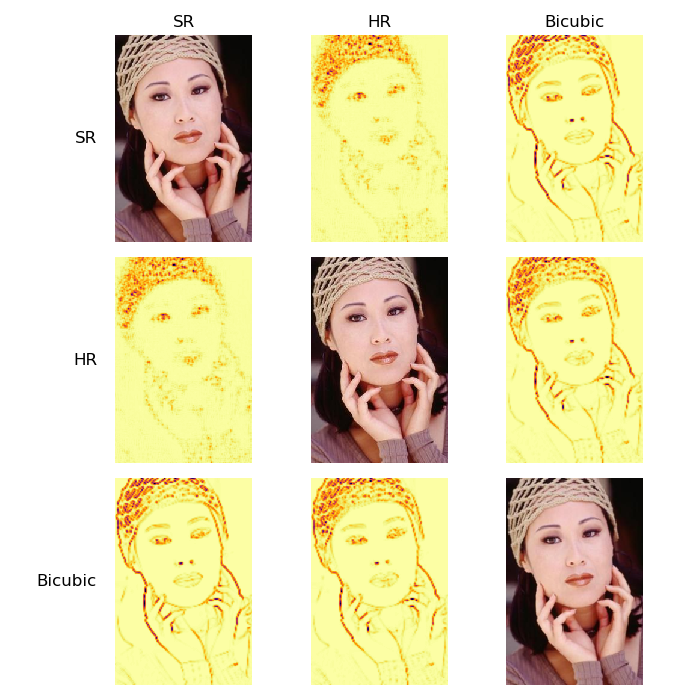

In [28]:
%matplotlib notebook
set5 = Set5()
set5.visualize(4)

## Super-resolute yourself

With the following scripr found [here](https://colbrydi.github.io/accessing-a-computers-camera-inside-of-jupyter-without-installing-opencv-also-works-in-jupyterhub.html) hopefully everyone will be able to acces their webcam through jupyter notebook.
Take selfies until you are happy with your looks and then execute the cell below in order to save them. Feel free to take as many as you like, but please note that it takes some time to pass the pictures through DRLN and you maybe do not want to overdo it :D.
The pictures will be saved in the LR/Demo folder. You can put other pictures there as well.

In [2]:
# Code developed by Dirk Colbry
# This code snipit tries to read from your computer's camera.  It is not fully tested so it may not work for everyone.

from IPython.display import HTML

main_text = """
<video id="video" width="320" height="240" autoplay></video>
<button id="snap">Snap Photo</button>
<canvas id="canvas" width="320" height="240"></canvas>

<script>
// Grab elements, create settings, etc.
var video = document.getElementById('video');

// Get access to the camera!
if(navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
    // Not adding `{ audio: true }` since we only want video now
    navigator.mediaDevices.getUserMedia({ video: true }).then(function(stream) {
        //video.src = window.URL.createObjectURL(stream);
        //video.play();
        video.srcObject=stream;
        video.play();
    });
}

// Elements for taking the snapshot
var canvas = document.getElementById('canvas');
var context = canvas.getContext('2d');
var video = document.getElementById('video');

// Trigger photo take
document.getElementById("snap").addEventListener("click", function() {
	context.drawImage(video, 0, 0, 320, 240);
    var myCanvas = document.getElementById('canvas');
    var image = myCanvas.toDataURL("image/png");
    IPython.notebook.kernel.execute("print('testing')")
    IPython.notebook.kernel.execute("image = '" + image + "'")
});
</script>

"""
HTML(main_text)

In [35]:
pil_im = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1])))
fname = datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")
im3 = np.array(pil_im)
im3 = im3[:,:,0:3]
im = Image.fromarray(im3)
im.save(f"LR/Demo/super_selfie_{fname}.png")

By including the -demo flag I added (please note I had to alter the original code a bit in order to make the demo convienient) you can now pass your pictures through the network. You can also put every other image you like in the LR/Demo folder, however, at least for me too big ones cause problems because they are computationally very costly.

In [36]:
%%bash
cd code
CUDA_VISIBLE_DEVICES=0 python main.py --cpu --demo --data_test MyImage --scale 2 --model DRLN --n_feats 64 --pre_train ../TrainedModels/DRLN_BIX2/DRLN_BIX2.pt --test_only --save_results --chop --save 'DRLN_Demo'  --testpath ../LR --testset Demo

Making model...
Loading model from ../TrainedModels/DRLN_BIX2/DRLN_BIX2.pt

Evaluation:
[MyImage x2]	PSNR: 0.000 (Best: 0.000 @epoch 1)
Total time: 33.73s, ave time: 16.87s



100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.73s/it]


In [37]:
class Demo:
    def __init__(self):
        lr_p = 'LR/Demo'
        sr_p = 'SR/DRLN_Demo/Demo'
        lr_n = glob.glob('LR/Demo/*.png')
        sr_n = glob.glob('SR/DRLN_Demo/Demo/*.png')
        assert  os.listdir(lr_p)==os.listdir(sr_p), "make sure your lr and sr pictures match up"
        self.srs = [plt.imread(f) for f in sr_n]
        self.lrs = [plt.imread(f) for f in lr_n]
        self.bicubics = [bicubic(f, self.srs[0].shape) for f in lr_n]
        self.n = len(self.lrs)
        

    def visualize(self, n=0, random=False):
        """Visualizing your demo pictures inluding original LR, Bicubic Interpolation and SR.
        
        Parameters:
        n (int): Nr of the demo picture in the Demo folder to be visualized.
        random (bool): Whether to just choos a random picture.
        """
        n = n%self.n
        if random:
            n = np.random.randint(self.n)
        gs = gridspec.GridSpec(2,2)
        fig = plt.figure(figsize=(7,7))
        ax = plt.subplot(gs[0,0:2])
        ax.imshow(self.lrs[n])
        ax.set_title("Original Low Resolution")
        
        ax1 = plt.subplot(gs[1,0])
        ax1.imshow(self.bicubics[n])
        ax1.set_title("Bicubic")
        
        ax2 = plt.subplot(gs[1,1], sharex=ax1, sharey=ax1)
        ax2.imshow(self.srs[n])
        ax2.set_title("Super Resolution")
        [a.set_axis_off() for a in [ax, ax1, ax2]]
        plt.show()
    

You can now choose which image you want to look or just take a random glimpse, comparing your super resoluted self to a bicubic interpolation.

<IPython.core.display.Javascript object>


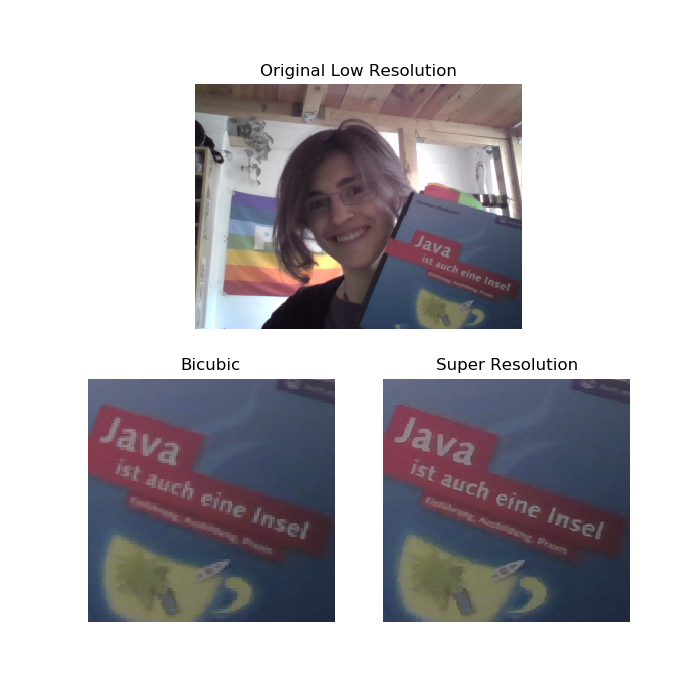

In [38]:
%matplotlib notebook
demo = Demo()
demo.visualize(0)